# Disaggregation

In [1]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation

### Dividing data into train and test set

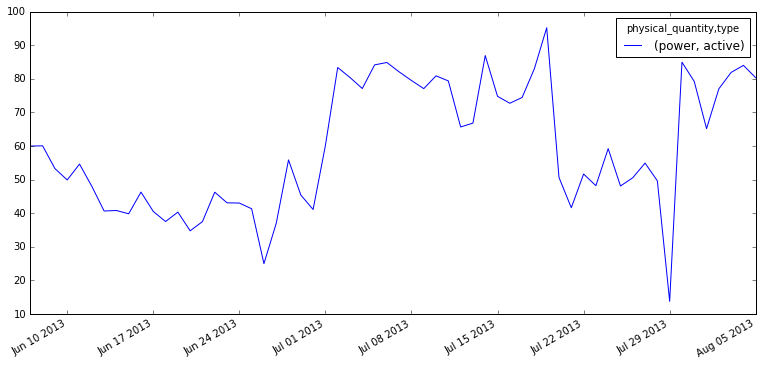

In [46]:
train = DataSet('/nilmtk/data/iawe.h5')
test = DataSet('/nilmtk/data/iawe.h5')
#test.buildings[1].elec #.mains() #.power_series_all_data().head()
fridge = test.buildings[1].elec['fridge']
df = next(fridge.load())
df = next(fridge.load(ac_type='active', sample_period=60*60*24)) #dia a dia
df.plot()
#test.elecs()

Let us use building 1 for demo purposes

In [24]:
building = 1

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


Let's split data at April 30th

In [47]:
train.set_window(end="24-6-2013")
test.set_window(start="1-7-2013")


train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

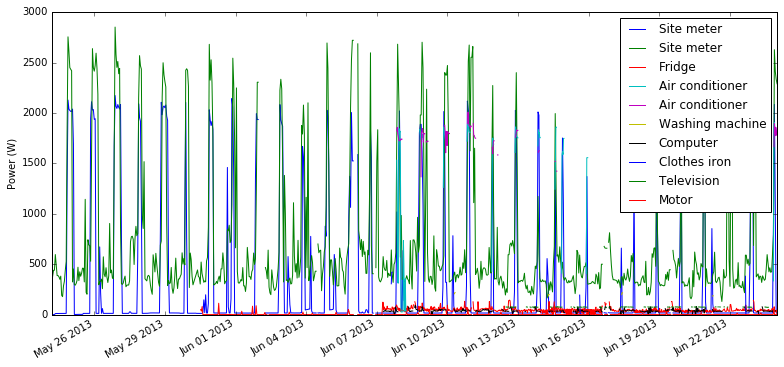

In [51]:
train_elec.plot()

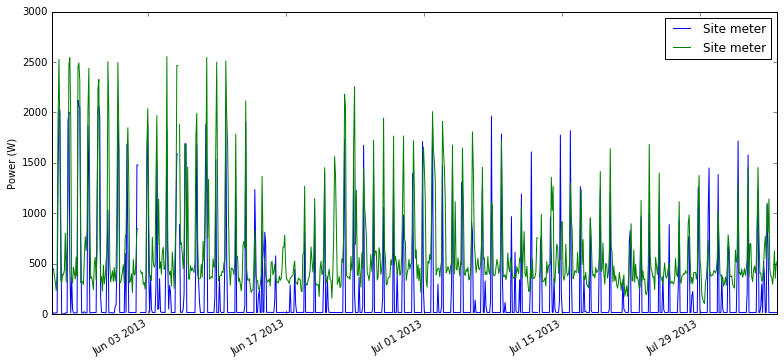

In [49]:
test_elec.mains().plot() #Agrega todas as medicoes

REDD data set has got appliance level data sampled every 3 or 4 seconds and mains data sampled every 1 second. Let us verify the same.

In [52]:
fridge_meter = train_elec['fridge']

In [53]:
fridge_df = next(fridge_meter.load())

In [54]:
fridge_df.head()

physical_quantity            power         frequency    power current  \
type                      apparent active            reactive           
2013-06-07 05:30:00+05:30    2.486  0.111  50.070000    2.483   0.011   
2013-06-07 05:30:01+05:30    2.555  0.200  50.080002    2.547   0.011   
2013-06-07 05:30:02+05:30    2.485  0.152  50.080002    2.480   0.011   
2013-06-07 05:30:03+05:30    2.449  0.159  50.060001    2.444   0.010   
2013-06-07 05:30:04+05:30    2.519  0.215  50.060001    2.510   0.011   

physical_quantity             voltage  
type                                   
2013-06-07 05:30:00+05:30  235.070007  
2013-06-07 05:30:01+05:30  235.020004  
2013-06-07 05:30:02+05:30  234.979996  
2013-06-07 05:30:03+05:30  235.000000  
2013-06-07 05:30:04+05:30  234.949997

In [55]:
mains = train_elec.mains()

In [56]:
mains_df = next(mains.load())

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


In [57]:
mains_df.head()

physical_quantity,power,power factor,power,voltage,power,current,frequency
type,apparent,NaN,active,apparent,reactive,NaN,apparent
2013-05-24 05:30:00+05:30,295.160004,NaN,282.744995,NaN,-52.148102,NaN,NaN
2013-05-24 05:30:01+05:30,307.010010,NaN,288.757996,NaN,-59.433601,NaN,NaN
2013-05-24 05:30:02+05:30,307.010010,NaN,288.757996,NaN,-59.433601,NaN,NaN
2013-05-24 05:30:03+05:30,313.783997,NaN,297.394012,NaN,-48.224499,NaN,NaN
2013-05-24 05:30:04+05:30,324.006012,NaN,303.722992,NaN,-55.869999,NaN,NaN


Since, both of these are sampled at different frequencies, we will downsample both to 1 minute resolution. We will also select the top-5 appliances in terms of energy consumption and use them for training our FHMM and CO models.

### Selecting top-5 appliances

In [58]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

10/10 ElecMeter(instance=12, building=1, dataset='iAWE', appliances=[Appliance(type='motor', instance=1)])

In [59]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=10, building=1, dataset='iAWE', appliances=[Appliance(type='television', instance=1)])
)

### Training and disaggregation

#### FHMM

In [60]:
start = time.time()
from nilmtk.disaggregate import fhmm_exact
fhmm = fhmm_exact.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute. 
# If instead of top_5 we wanted to train on all appliance, we would write 
# fhmm.train(train_elec, sample_period=60)
fhmm.train(top_5_train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=1, dataset='iAWE', appliances=[Appliance(type='television', instance=1)])'
Runtime = 14.3215510845 seconds.


In [62]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=60)):
    chunk_drop_na = chunk.dropna()
    pred[i] = fhmm.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = next(meter.load(sample_period=60))
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i])}, index=next(iter(gt[i].values())).index).dropna()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='iAWE')     
Done loading data all meters for this chunk.


IndexError: index 0 is out of bounds for axis 0 with size 0

In [63]:
# If everything can fit in memory
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

# Having the same order of columns
gt_overall = gt_overall[pred_overall.columns]

ValueError: All objects passed were None

In [18]:
#Intersection of index
gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

In [19]:
local_timezone = train.metadata['timezone']

In [20]:
common_index_local = common_index_utc.tz_convert(local_timezone)

In [21]:
gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

In [22]:
gt_overall.head()

,"ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])","ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])","ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])","ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])","ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])"
2011-04-30 00:01:00-04:00,1131.0,76.0,6.0,31.0,4.0
2011-04-30 00:02:00-04:00,1128.0,76.0,6.0,29.0,4.0
2011-04-30 00:03:00-04:00,1133.0,76.0,6.0,28.0,4.0
2011-04-30 00:04:00-04:00,1129.0,77.0,6.0,28.0,4.0
2011-04-30 00:05:00-04:00,1130.0,76.0,6.0,28.0,4.0


Using prettier names!

In [23]:
appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

In [24]:
pred_overall.head()

,Dish washer,Light,Fridge,Sockets,Microwave
2011-04-30 00:01:00-04:00,0.0,2.0,194.0,22.0,1098.0
2011-04-30 00:02:00-04:00,0.0,2.0,194.0,22.0,1098.0
2011-04-30 00:03:00-04:00,0.0,2.0,194.0,22.0,1098.0
2011-04-30 00:04:00-04:00,0.0,2.0,194.0,22.0,1098.0
2011-04-30 00:05:00-04:00,0.0,2.0,194.0,22.0,1098.0


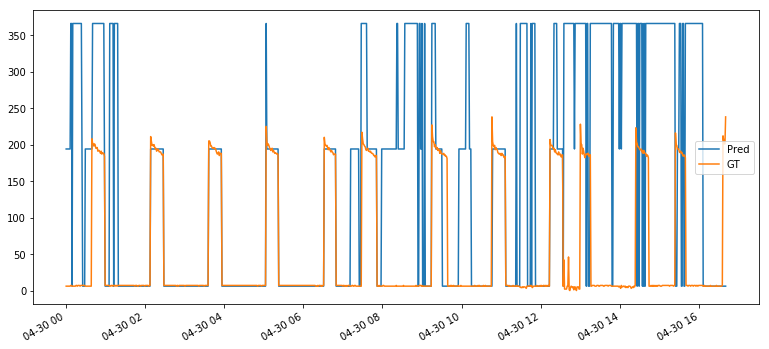

In [25]:
pred_overall['Fridge'].head(1000).plot(label="Pred")
gt_overall['Fridge'].head(1000).plot(label="GT")
plt.legend()

In [26]:
from sklearn.metrics import mean_squared_error

In [27]:
rms_error = {}
for appliance in gt_overall.columns:
    rms_error[appliance] = np.sqrt(mean_squared_error(gt_overall[appliance], pred_overall[appliance]))

In [28]:
pd.Series(rms_error)

Dish washer    182.148235
Fridge         174.803628
Light           92.915403
Microwave      177.634751
Sockets         46.909119
dtype: float64